# 230968078 - Ishan Suryawanshi - Week 3 - Part A - Fashion Mnist Dataset


In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Image dimensions:", train_images.shape[1:])

Number of classes: 10
Image dimensions: (28, 28)


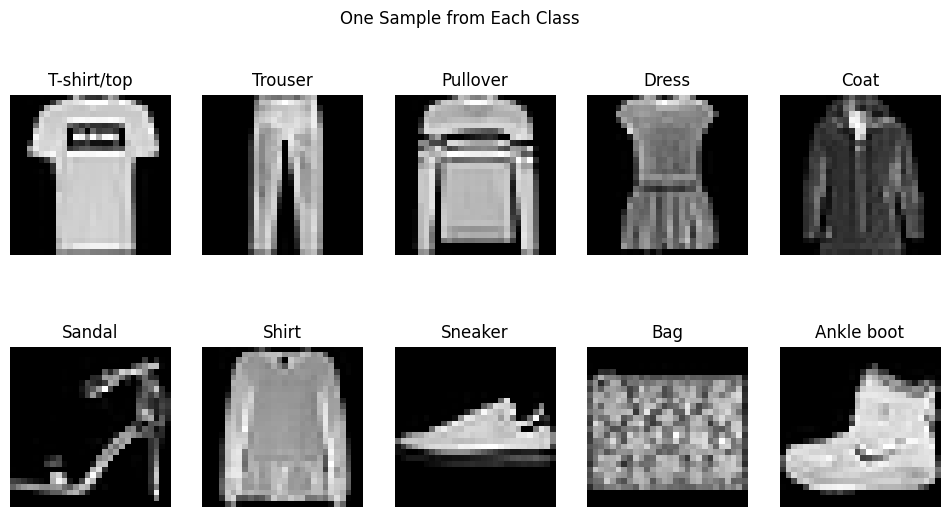

In [6]:
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    # find the first occurrence of class i
    idx = np.where(train_labels == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[idx], cmap="gray")
    plt.title(class_names[i])
    plt.axis("off")
plt.suptitle("One Sample from Each Class")
plt.show()

In [7]:
# normalizing the images (bring each pixel value from 0-255 to 0-1)
train_images, test_images = train_images / 255.0, test_images / 255.0
# reshaping the input (28 x 28 x 1)
# greyscale images to no rgb layers
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_labels.shape[0], 28, 28, 1))

In [8]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [9]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

### Hyperparameter tuning to find the best model for FCNN

In [10]:
def build_model(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28, 1)))
  num_layers = hp.Choice('layers', [1, 2, 3])
  reg_type = hp.Choice('regularization', ['none', 'l1', 'l2'])

  if reg_type == 'l1':
    reg = regularizers.l1(0.01)
  elif reg_type == 'l2':
    reg = regularizers.l2(0.01)
  else:
    reg = None

  model.add(Dense(128, activation='relu', kernel_regularizer=reg))
  if num_layers >= 2:
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
  if num_layers == 3:
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
  model.add(Dense(10, activation='softmax'))

  lr = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
  model.compile(
      optimizer=Adam(lr),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model


In [11]:
results = []

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True
)

tuner.search(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
_, best_val_acc = best_model.evaluate(val_images, val_labels, verbose=0)

results.append({
      "layers": best_hps.get("layers"),
      "regularization": best_hps.get("regularization"),
      "learning_rate": best_hps.get("learning_rate"),
      "val_accuracy": best_val_acc
  })

Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.19691666960716248

Best val_accuracy So Far: 0.890250027179718
Total elapsed time: 00h 05m 28s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
results

[{'layers': 2,
  'regularization': 'none',
  'learning_rate': 0.001,
  'val_accuracy': 0.890250027179718}]

In [13]:
result = results[0]

In [14]:
def build_best_model(layers, regularization, lr):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(128, activation="relu"))
    if layers >= 2:
      model.add(Dense(64, activation="relu"))
    if layers == 3:
      model.add(Dense(32, activation="relu"))
    if regularization != "none":
        reg = regularizers.l1(0.01) if regularization == "l1" else regularizers.l2(0.01)
        for layer in model.layers:
            if isinstance(layer, Dense):
                layer.kernel_regularizer = reg

    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [15]:
fcnn = build_best_model(
    layers=result["layers"],
    regularization=result["regularization"],
    lr=result["learning_rate"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
fcnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history1 = fcnn.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7734 - loss: 0.6605 - val_accuracy: 0.8421 - val_loss: 0.4349
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8617 - loss: 0.3874 - val_accuracy: 0.8646 - val_loss: 0.3737
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8709 - loss: 0.3414 - val_accuracy: 0.8645 - val_loss: 0.3757
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8823 - loss: 0.3177 - val_accuracy: 0.8837 - val_loss: 0.3326
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8921 - loss: 0.2903 - val_accuracy: 0.8767 - val_loss: 0.3406
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8967 - loss: 0.2793 - val_accuracy: 0.8812 - val_loss: 0.3344
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9006 - loss: 0.2631 - val_accuracy: 0.8831 - val_loss: 0.3282
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9035 - loss: 0.2557 -

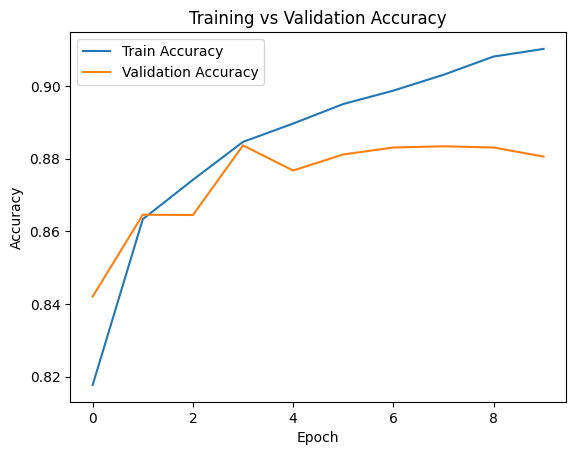

In [18]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
test_labels_ = np.argmax(test_labels, axis=1)

In [23]:
y_pred1 = fcnn.predict(test_images)
y_pred1 = np.argmax(y_pred1, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
test_acc = accuracy_score(test_labels_, y_pred1)

# Calculating precision, recall, and F1-score for multiclass (macro average)
test_prec = precision_score(test_labels_, y_pred1, average='macro', zero_division=1)
test_rec = recall_score(test_labels_, y_pred1, average='macro', zero_division=1)
test_f1 = f1_score(test_labels_, y_pred1, average='macro', zero_division=1)

print("\n===== Test Set Metrics (Multiclass) =====")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-score:  {test_f1:.4f}")


===== Test Set Metrics (Multiclass) =====
Accuracy:  0.8724
Precision: 0.8729
Recall:    0.8724
F1-score:  0.8712


## Training the CNN Model 1

In [26]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, (5, 5), strides=1, padding='valid', activation='relu', input_shape=(28, 28, 1)))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn1.add(Flatten())
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
cnn1.compile(
    optimizer=Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
cnn1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,742 (1.77 MB)

 Trainable params: 462,742 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history2 = cnn1.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8013 - loss: 0.5816 - val_accuracy: 0.8572 - val_loss: 0.3762
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.8762 - loss: 0.3332 - val_accuracy: 0.8711 - val_loss: 0.3489
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8873 - loss: 0.2983 - val_accuracy: 0.8777 - val_loss: 0.3429
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8931 - loss: 0.2858 - val_accuracy: 0.8810 - val_loss: 0.3481
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9020 - loss: 0.2602 - val_accuracy: 0.8687 - val_loss: 0.3951
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.9070 - loss: 0.2497 - val_accuracy: 0.8721 - val_loss: 0.3968
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9080 - loss: 0.2391 - val_accuracy: 0.8684 - val_loss: 0.4198
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.9138 -

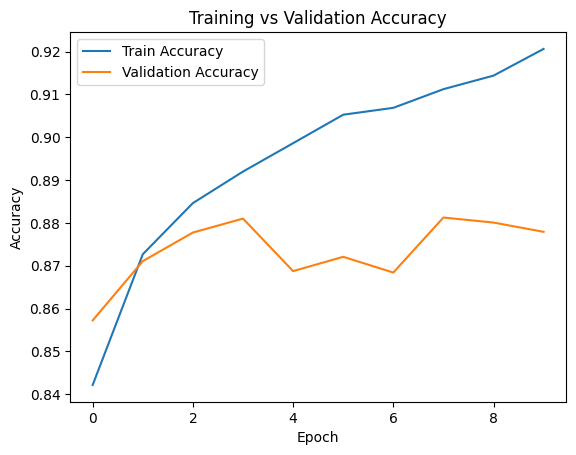

In [30]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
test_loss1, test_acc1 = cnn1.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_acc1:.4f}")
print(f"Test Loss: {test_loss1:.4f}")

313/313 - 2s - 6ms/step - accuracy: 0.8708 - loss: 0.4827

Test Accuracy: 0.8708
Test Loss: 0.4827


## Training CNN Model 2

In [33]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=(28, 28, 1)))
cnn2.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn2.add(Flatten())
cnn2.add(Dense(100, activation='relu'))
cnn2.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
cnn2.compile(
    optimizer=Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
cnn2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,478 (1.80 MB)

 Trainable params: 471,478 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history3 = cnn2.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 47ms/step - accuracy: 0.7554 - loss: 0.6825 - val_accuracy: 0.8633 - val_loss: 0.3721
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.8737 - loss: 0.3364 - val_accuracy: 0.8780 - val_loss: 0.3362
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 70s 47ms/step - accuracy: 0.8833 - loss: 0.3076 - val_accuracy: 0.8754 - val_loss: 0.3439
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8926 - loss: 0.2870 - val_accuracy: 0.8827 - val_loss: 0.3258
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.8962 - loss: 0.2760 - val_accuracy: 0.8748 - val_loss: 0.3680
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - accuracy: 0.9016 - loss: 0.2627 - val_accuracy: 0.8884 - val_loss: 0.3533
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.9055 - loss: 0.2545 - val_accuracy: 0.8866 - val_loss: 0.3165
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 70s 47ms/step - accuracy: 0.9065 -

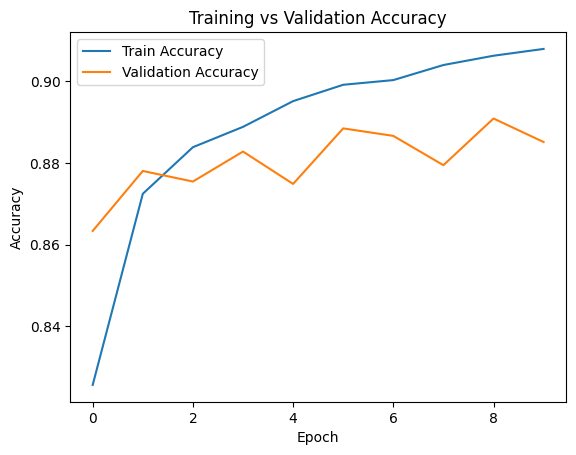

In [37]:
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
test_loss2, test_acc2 = cnn2.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_acc2:.4f}")
print(f"Test Loss: {test_loss2:.4f}")

313/313 - 4s - 14ms/step - accuracy: 0.8800 - loss: 0.3562

Test Accuracy: 0.8800
Test Loss: 0.3562


## Comparing the accuracy of all the three models

Fully Connected Neural network: 87.24%<br />
CNN Architecture 1: 87.08%<br />
CNN Architecture 2: 88.00%<br />

We can see the three models perform roughly the same, with the second CNN network performing slightly better.

Total Parameters for all the models: <br />
Fully Connected Neural network: 109386<br />
CNN Architecture 1: 462742 <br />
CNN Architecture 2: 471478 <br />

We can see that CNNs have much more parameters to train. Most of the parameters for the Convolutional neural networks come from the dense layer.
